In [1]:
import RNA
import numpy as np
import matplotlib.pyplot as plt
import os

from utils import calc_MCC, dict_dot_bracket, list_dot_bracket, forna_display, parse_rdat
from penalties import penalize_barriers, get_penalties, penalize_barriers_seq

In [2]:
shape_data = {}
rdat_files = sorted(['flouride_test/'+f for f in os.listdir('flouride_test') if 'rdat' in f])
#rdat_files = ['SRP_test/'+'SRPECLI_BZCN_0001.rdat.txt']
for r in rdat_files:
    shape_data[r.strip('flouride_test/FLOURSW_').strip('.rdat.txt')] = parse_rdat(r)

# Create dummy data with no constraints
shape_data['kinetic20'] = {}
shape_data['no_constraints'] = {}
for l in shape_data['BZCN_0001']:
    shape_data['kinetic20'][l] = {
        'seq' : shape_data['BZCN_0001'][l]['seq'],
        'react' : [0 for _ in range(len(shape_data['BZCN_0001'][l]['seq']))]
    }
    shape_data['no_constraints'][l] = {
        'seq' : shape_data['BZCN_0001'][l]['seq'],
        'react' : [0 for _ in range(len(shape_data['BZCN_0001'][l]['seq']))]
    }
    
md = RNA.md()
md.temperature = 37

In [3]:
# Calculate folding pathways for each dataset
last_structure = ''
for n, d in shape_data.items():
    print(f'Working on {n}')
    for length in d.keys():
        subseq = d[length]['seq']
        reactivities = d[length]['react']
        # Shape-defined fold
        fc = RNA.fold_compound(subseq, md)
        if n not in ['no_constraints', 'kinetic20']:
            fc.sc_add_SHAPE_deigan(reactivities, 2.6, -0.8)
        if n == 'kinetic20':
            step_info = {
                'last' : dict_dot_bracket(last_structure),
                'penalty' : 20
            }
            fc.sc_add_f(penalize_barriers)
            fc.sc_add_data(step_info)
        d[length]['mfe'] = fc.mfe()[0]
        last_structure = d[length]['mfe']

Working on BZCN_0001
Working on BZCN_0002
Working on BZCN_0003
Working on BZCN_0009
Working on BZCN_0011
Working on BZCN_0013
Working on BZCN_0015
Working on BZCN_0017
Working on BZCN_0019
Working on kinetic20
Working on no_constraints


In [ ]:
# TODO: DrTransformer with the many different sequences in the flouride set.

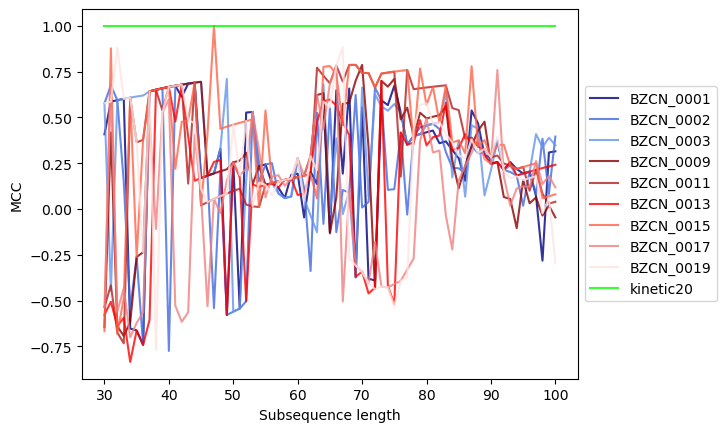

In [4]:
# Plot MCC at each length vs the no_constraints folding
# This at least tells us if if the kinetic method sees the same edges as the SHAPE data predicts
cols = {'BZCN_0001' : 'navy', 
        'BZCN_0002' : 'royalblue', 
        'BZCN_0003' : 'cornflowerblue', 
        'BZCN_0009' : 'darkred', 
        'BZCN_0011' : 'firebrick', 
        'BZCN_0013' : 'red',
        'BZCN_0015' : 'tomato',
        'BZCN_0017' : 'lightcoral',
        'BZCN_0019' : 'mistyrose',
        'kinetic20' : 'lime', 
        'drtransformer' : 'gold',
        'no_constraints' : 'black'}

fig, ax = plt.subplots()
for n, d in [it for it in list(shape_data.items()) if it[0] != 'no_constraints']:
#for n, d in [it for it in list(shape_data.items()) if it[0] != 'BZCN_0003']:
    x = list(d.keys()) # sequence lengths
    y = [calc_MCC(list_dot_bracket(d[l]['mfe']), list_dot_bracket(shape_data['no_constraints'][l]['mfe'])) for l in list(d.keys())]
    ax.plot(x, y, c=cols[n], alpha=0.8, label=n)

ax.set_xlabel('Subsequence length')
ax.set_ylabel('MCC')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

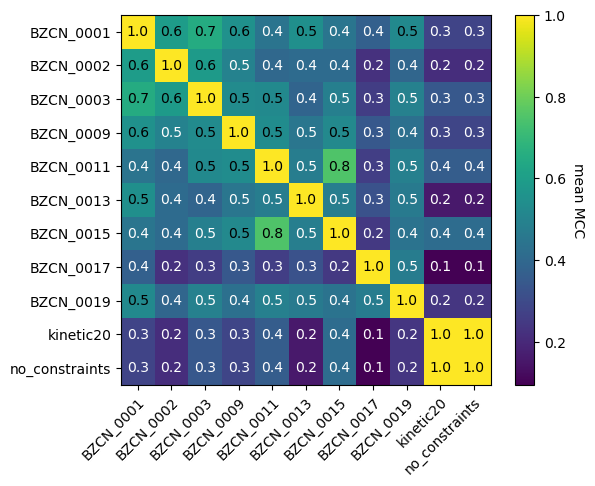

In [5]:
# plot mean MCC between different methods
fig, ax = plt.subplots()
corr = np.ones((len(shape_data.keys()), len(shape_data.keys())))
for i, (n1, d1) in enumerate(shape_data.items()):
    for j, (n2, d2) in enumerate(shape_data.items()):
        if i <= j:
            continue
        c = np.mean([calc_MCC(list_dot_bracket(d1[l]['mfe']), list_dot_bracket(d2[l]['mfe'])) for l in list(d1.keys())])
        corr[i, j] = c
        corr[j, i] = c

im = ax.imshow(corr, origin='upper')
ax.set_yticks(np.arange(len(shape_data.keys())), list(shape_data.keys()))
ax.set_xticks(np.arange(len(shape_data.keys())), list(shape_data.keys()), rotation=45, ha='right', rotation_mode="anchor")

cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('mean MCC', rotation=-90, va="bottom")

# annotate heatmap
threshold = im.norm(corr.max())/2
kw = dict(horizontalalignment="center",
          verticalalignment="center")
textcolors = ["white", "black"]
for i in range(len(corr)):
    for j in range(len(corr)):
        kw.update(color=textcolors[int(corr[i, j] > threshold)])
        text = im.axes.text(j, i, "{:.1f}".format(corr[i,j]), **kw)

plt.show()

In [6]:
# Let's try a single-value penalty sweep.  This isn't going to work, but its useful to see.

penalties = np.arange(5, 105, 5)
pred_at_pen = {}
for p in penalties:
    print("working on penalty =", p)
    pred_at_pen[p] = {}
    last_structure = ''
    for length in shape_data['kinetic20'].keys():
        subseq = shape_data['kinetic20'][length]['seq']
        fc = RNA.fold_compound(subseq, md)
        step_info = {
                'last' : dict_dot_bracket(last_structure),
                'penalty' : int(p)
            }
        fc.sc_add_f(penalize_barriers)
        fc.sc_add_data(step_info)

        pred_at_pen[p][length] = fc.mfe()[0]
        last_structure = pred_at_pen[p][length]

working on penalty = 5
working on penalty = 10
working on penalty = 15
working on penalty = 20
working on penalty = 25
working on penalty = 30
working on penalty = 35
working on penalty = 40
working on penalty = 45
working on penalty = 50
working on penalty = 55
working on penalty = 60
working on penalty = 65
working on penalty = 70
working on penalty = 75
working on penalty = 80
working on penalty = 85
working on penalty = 90
working on penalty = 95
working on penalty = 100


In [7]:
penalty_sweep = np.empty((len(penalties), len(shape_data.keys())))
for i, p in enumerate(penalties):
    for j, k in enumerate(shape_data.keys()):
        penalty_sweep[i][j] = np.mean([calc_MCC(list_dot_bracket(pred_at_pen[p][l]), list_dot_bracket(shape_data[k][l]['mfe'])) for l in list(pred_at_pen[20].keys())])

In [8]:
best  = {
    "wt" : {"pen" : -1, "mcc" : -1},
    "muts" : {"pen" : -1, "mcc" : -1},
    "all" : {"pen" : -1, "mcc" : -1}
}
print(f"Penalty\tBzCN\tDMS\tAll")
for i, row in enumerate(penalty_sweep):
    wt = np.mean(row[0:4])
    muts = np.mean(row[4:9])
    all = np.mean(row[0:9])
    best['wt'] = {"pen" : i, "mcc" : wt} if wt > best['wt']['mcc'] else best['wt']
    best['muts'] = {"pen" : i, "mcc" : muts} if muts > best['muts']['mcc'] else best['muts']
    best['all'] = {"pen" : i, "mcc" : all} if all > best['all']['mcc'] else best['all']
    print(f"{penalties[i]}\t{wt:.3f}\t{muts:.3f}\t{all:.3f}")

print()
print("Best!")
for k, v in best.items():
    print(f"{k}:\tpenalty={penalties[v['pen']]} MCC={v['mcc']:.3f}")

Penalty	BzCN	DMS	All
5	0.280	0.253	0.265
10	0.280	0.253	0.265
15	0.280	0.253	0.265
20	0.280	0.253	0.265
25	0.280	0.253	0.265
30	0.277	0.251	0.263
35	0.277	0.251	0.263
40	0.277	0.251	0.263
45	0.277	0.251	0.263
50	0.277	0.251	0.263
55	0.277	0.251	0.263
60	0.277	0.251	0.263
65	0.277	0.251	0.263
70	0.277	0.251	0.263
75	0.277	0.251	0.263
80	0.277	0.251	0.263
85	0.277	0.251	0.263
90	0.297	0.281	0.288
95	0.297	0.281	0.288
100	0.297	0.281	0.288

Best!
wt:	penalty=90 MCC=0.297
muts:	penalty=90 MCC=0.281
all:	penalty=90 MCC=0.288


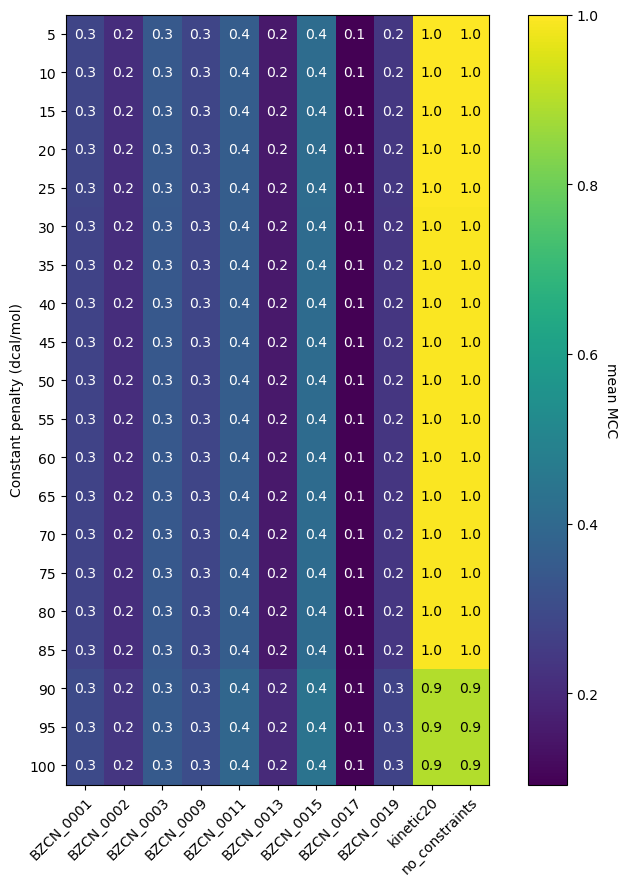

In [9]:
fig, ax = plt.subplots(figsize=(10, 10))

im = ax.imshow(penalty_sweep, origin='upper')
ax.set_yticks(np.arange(len(penalties)), penalties)
ax.set_xticks(np.arange(len(shape_data.keys())), list(shape_data.keys()), rotation=45, ha='right', rotation_mode="anchor")
ax.set_ylabel('Constant penalty (dcal/mol)')

cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('mean MCC', rotation=-90, va="bottom")

# annotate heatmap
threshold = im.norm(penalty_sweep.max())/2
kw = dict(horizontalalignment="center",
          verticalalignment="center")
textcolors = ["white", "black"]
for i in range(len(penalty_sweep)):
    for j in range(len(shape_data.keys())):
        kw.update(color=textcolors[int(penalty_sweep[i, j] > threshold)])
        text = im.axes.text(j, i, "{:.1f}".format(penalty_sweep[i, j]), **kw)

plt.show()

In [10]:
# Let's try the situation where it's dependent on the base pair broken

percents = np.arange(0.01, 0.262, 0.012)
pred_at_cent = {}
for p in percents:
    print("Working on percentage = {:.3f}".format(p), end='; ')
    pred_at_cent[p] = {}
    p_list = []
    last_structure = ''
    for length in shape_data['kinetic20'].keys():
        subseq = shape_data['kinetic20'][length]['seq']
        fc = RNA.fold_compound(subseq, md)
        if last_structure != '':
            fc_last = RNA.fold_compound(subseq[:len(last_structure)], md)
            penalty_dict = get_penalties(last_structure, fc_last)
            p_list.extend([v for v in penalty_dict.values()])
        else:
            penalty_dict = {}
        step_info = {
            'last_dict' : dict_dot_bracket(last_structure),
            'penalty_dict' : penalty_dict,
            'penalty_percent' : p
            }
        fc.sc_add_f(penalize_barriers_seq)
        fc.sc_add_data(step_info)

        pred_at_cent[p][length] = fc.mfe()[0]
        last_structure = pred_at_cent[p][length]
    
    print("mean penalty = {:.0f}".format(np.mean(p_list)*p))

Working on percentage = 0.010; mean penalty = 4
Working on percentage = 0.022; mean penalty = 10
Working on percentage = 0.034; mean penalty = 15
Working on percentage = 0.046; mean penalty = 20
Working on percentage = 0.058; mean penalty = 25
Working on percentage = 0.070; mean penalty = 31
Working on percentage = 0.082; mean penalty = 36
Working on percentage = 0.094; mean penalty = 41
Working on percentage = 0.106; mean penalty = 46
Working on percentage = 0.118; mean penalty = 52
Working on percentage = 0.130; mean penalty = 57
Working on percentage = 0.142; mean penalty = 62
Working on percentage = 0.154; mean penalty = 68
Working on percentage = 0.166; mean penalty = 73
Working on percentage = 0.178; mean penalty = 78
Working on percentage = 0.190; mean penalty = 83
Working on percentage = 0.202; mean penalty = 89
Working on percentage = 0.214; mean penalty = 94
Working on percentage = 0.226; mean penalty = 99
Working on percentage = 0.238; mean penalty = 105
Working on percentag

In [11]:
cent_sweep = np.empty((len(percents), len(shape_data.keys())))
for i, p in enumerate(percents):
    for j, k in enumerate(shape_data.keys()):
        cent_sweep[i][j] = np.mean([calc_MCC(list_dot_bracket(pred_at_cent[p][l]), list_dot_bracket(shape_data[k][l]['mfe'])) for l in list(pred_at_cent[0.01].keys())])

In [16]:
best  = {
    "wt" : {"pen" : -1, "mcc" : -1},
    "muts" : {"pen" : -1, "mcc" : -1},
    "all" : {"pen" : -1, "mcc" : -1}
}
print(f"Penalty\tBzCN\tDMS\tAll")
for i, row in enumerate(cent_sweep):
    wt = np.mean(row[0:4])
    muts = np.mean(row[4:9])
    all = np.mean(row[0:9])
    best['wt'] = {"pen" : i, "mcc" : wt} if wt > best['wt']['mcc'] else best['wt']
    best['muts'] = {"pen" : i, "mcc" : muts} if muts > best['muts']['mcc'] else best['muts']
    best['all'] = {"pen" : i, "mcc" : all} if all > best['all']['mcc'] else best['all']
    print(f"{percents[i]:.3f}\t{wt:.3f}\t{muts:.3f}\t{all:.3f}")

print()
print("Best!")
for k, v in best.items():
    print(f"{k}:\tpenalty={percents[v['pen']]:.3f} MCC={v['mcc']:.3f}")

Penalty	BzCN	DMS	All
0.010	0.280	0.253	0.265
0.022	0.280	0.253	0.265
0.034	0.280	0.253	0.265
0.046	0.280	0.253	0.265
0.058	0.280	0.253	0.265
0.070	0.280	0.253	0.265
0.082	0.277	0.251	0.263
0.094	0.277	0.251	0.263
0.106	0.277	0.251	0.263
0.118	0.277	0.251	0.263
0.130	0.277	0.251	0.263
0.142	0.277	0.251	0.263
0.154	0.277	0.251	0.263
0.166	0.277	0.251	0.263
0.178	0.277	0.251	0.263
0.190	0.277	0.251	0.263
0.202	0.277	0.251	0.263
0.214	0.277	0.251	0.263
0.226	0.277	0.251	0.263
0.238	0.297	0.281	0.288
0.250	0.297	0.281	0.288

Best!
wt:	penalty=0.238 MCC=0.297
muts:	penalty=0.238 MCC=0.281
all:	penalty=0.238 MCC=0.288


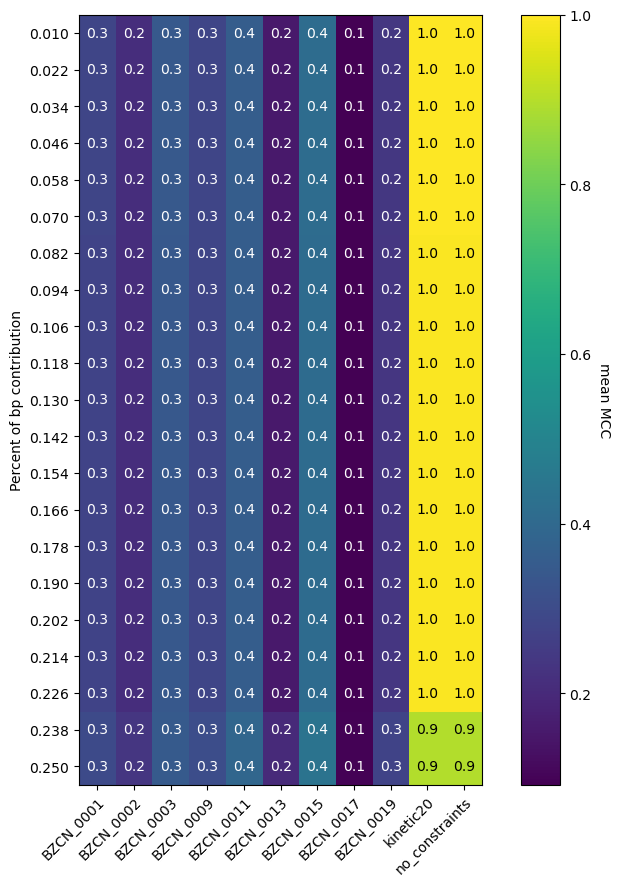

In [13]:
fig, ax = plt.subplots(figsize=(10, 10))

im = ax.imshow(cent_sweep, origin='upper')
ax.set_yticks(np.arange(len(percents)), ['{:.3f}'.format(f) for f in percents])
ax.set_xticks(np.arange(len(shape_data.keys())), list(shape_data.keys()), rotation=45, ha='right', rotation_mode="anchor")
ax.set_ylabel('Percent of bp contribution')

cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('mean MCC', rotation=-90, va="bottom")

# annotate heatmap
threshold = im.norm(cent_sweep.max())/2
kw = dict(horizontalalignment="center",
          verticalalignment="center")
textcolors = ["white", "black"]
for i in range(len(cent_sweep)):
    for j in range(len(shape_data.keys())):
        kw.update(color=textcolors[int(cent_sweep[i, j] > threshold)])
        text = im.axes.text(j, i, "{:.1f}".format(cent_sweep[i, j]), **kw)

plt.show()